Processing ../data/frequency_sweep_310
Processing ../data/frequency_sweep_310/20250204
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift_seg_forces.dat
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0364freqshift_seg_forces.dat
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0727freqshift_seg_forces.dat
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.1091freqshift_seg_forces.dat
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.1455freqshift_seg_forces.dat
Processing ../data/frequency_sweep_310/20250204/ciliate_310fil_9000blob_8.00R_0.0010torsion_0.2182tilt_0.3000f_eff_1.4

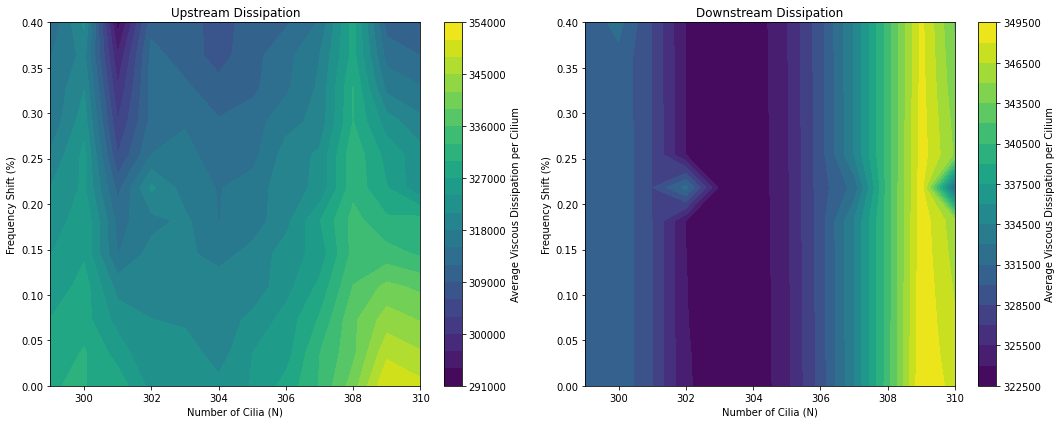

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_and_process_data(file_path):
    """Load data and separate into upstream and downstream segments"""
    data = np.loadtxt(file_path)
    time = data[:, 0]
    
    # Calculate number of segments from data shape
    n_segments = (data.shape[1] - 1) // 6
    
    # Extract first 20 segments (downstream)
    down_indices = np.array([range(1+6*i, 4+6*i) for i in range(20)]).flatten()
    downstream = data[:, down_indices].reshape(data.shape[0], -1, 3)
    
    # Extract last 20 segments (upstream)
    up_indices = np.array([range(1+6*i, 4+6*i) for i in range(n_segments-20, n_segments)]).flatten()
    upstream = data[:, up_indices].reshape(data.shape[0], -1, 3)
    
    return time, upstream, downstream

def calculate_dissipation(forces, velocities):
    """Calculate viscous dissipation as dot product of forces and velocities"""
    return np.sum(forces * velocities, axis=(1, 2))

# Base directory for data
base_dir = Path('../data')

# Lists to store results
results = []

# Scan through directories
for dir_name in base_dir.glob('frequency_sweep_*'):
    print(f'Processing {dir_name}')
    N = int(dir_name.name.split('_')[-1])
    
    # Get all date subdirectories
    date_dirs = list(dir_name.glob('*'))
    if not date_dirs:
        continue
        
    # Process each date directory
    for data_dir in date_dirs:
        print(f'Processing {data_dir}')
        # Process all matching files in this directory
        for force_file in data_dir.glob('*_seg_forces.dat'):
            print(f'Processing {force_file}')
            # Extract frequency shift from filename
            fname = force_file.name
            f = float(fname.split('freqshift_')[0].split('_')[-1])
            
            # Construct velocity filename
            vel_file = force_file.parent / fname.replace('seg_forces', 'seg_vels')
            
            if vel_file.exists():
                # Load force and velocity data
                _, forces_up, forces_down = load_and_process_data(force_file)
                _, vels_up, vels_down = load_and_process_data(vel_file)
                
                # Calculate dissipation for each region
                R_up = np.mean(calculate_dissipation(forces_up, vels_up))
                R_down = np.mean(calculate_dissipation(forces_down, vels_down))
                
                # Store results
                results.append({
                    'N': N,
                    'f': f,
                    'R_up_per_N': R_up/20,  # Normalize by number of segments in each region
                    'R_down_per_N': R_down/20
                })


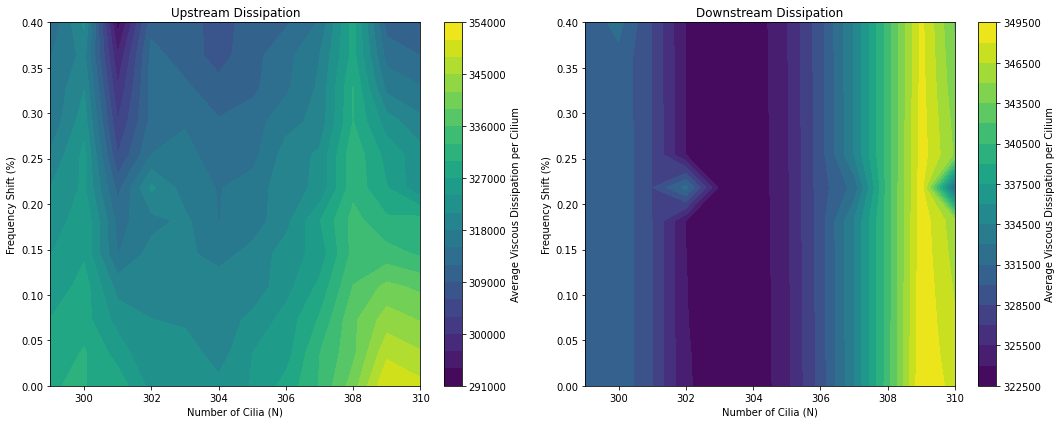

In [2]:

# Convert results to dataframe for easier plotting
import pandas as pd
df = pd.DataFrame(results)

# Handle outliers (as in your modifications)
outlier_conditions = [
    (df['N'] == 310) & (df['f'] == 0.2182),
    (df['N'] == 302) & (df['f'] == 0.2182),
    (df['N'] == 307) & (df['f'] == 0.2182),
    (df['N'] == 300) & (df['f'] == 0.4)
]

# Calculate averages excluding outliers
avg_up = df[~np.any(outlier_conditions, axis=0)]['R_up_per_N'].mean()
avg_down = df[~np.any(outlier_conditions, axis=0)]['R_down_per_N'].mean()

# Replace outlier values
for condition in outlier_conditions:
    df.loc[condition, 'R_up_per_N'] = avg_up
    df.loc[condition, 'R_down_per_N'] = avg_down

# Create separate contour plots for upstream and downstream
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for data, title, ax in [('R_up_per_N', 'Upstream', ax1), 
                       ('R_down_per_N', 'Downstream', ax2)]:
    
    # Prepare grid for contour
    pivot = df.pivot(index='f', columns='N', values=data)
    
    # Create contour plot
    cont = ax.contourf(pivot.columns, pivot.index, pivot.values, levels=20, cmap='viridis')
    plt.colorbar(cont, ax=ax, label='Average Viscous Dissipation per Cilium')
    ax.set_xlabel('Number of Cilia (N)')
    ax.set_ylabel('Frequency Shift (%)')
    ax.set_title(f'{title} Dissipation')

plt.tight_layout()
plt.show()

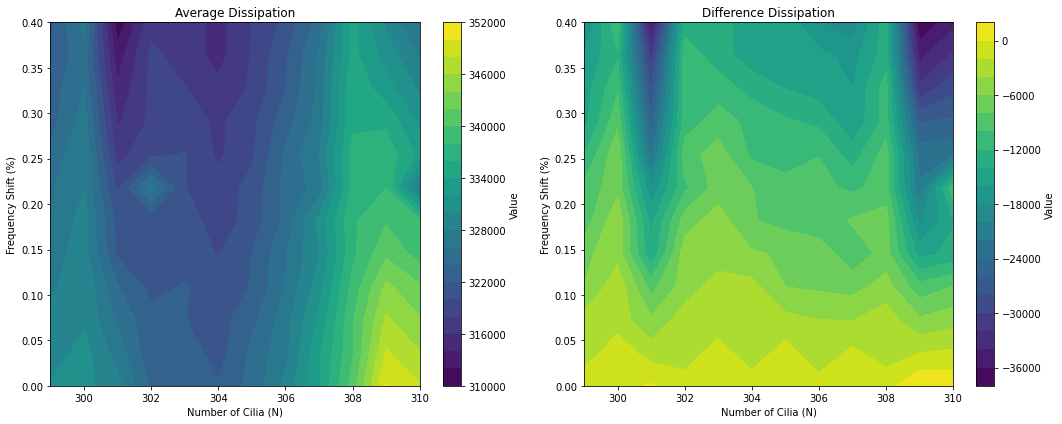

In [ ]:
# Calculate average and difference between upstream and downstream dissipation
df['R_avg_per_N'] = (df['R_up_per_N'] + df['R_down_per_N']) / 2
df['R_diff_per_N'] = df['R_up_per_N'] - df['R_down_per_N']

# Create separate contour plots for average and difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for data, title, ax in [('R_avg_per_N', 'Average', ax1), 
            ('R_diff_per_N', 'Difference', ax2)]:
  
  # Prepare grid for contour
  pivot = df.pivot(index='f', columns='N', values=data)
  
  # Create contour plot
  cont = ax.contourf(pivot.columns, pivot.index, pivot.values, levels=20, cmap='viridis')
  plt.colorbar(cont, ax=ax, label='Value')
  ax.set_xlabel('Number of Cilia (N)')
  ax.set_ylabel('Frequency Shift (%)')
  ax.set_title(f'{title} Dissipation')

plt.tight_layout()
plt.show()